# Data Bootcamp Final Project - Paleontology Database Analysis
##### Ravin Mehta, Veeraj Rangnekar, James Ellsworth

## Backend


---




#### Installations and Imports


In [ ]:
pip install geopandas

In [ ]:
# imports
import requests
import pandas as pd
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import geopandas as gpd
import math
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
pd.set_option("display.max_columns", 200)
pd.options.mode.chained_assignment = None

In [ ]:
# importing data via api call (can take around 5 minutes)
url = requests.get('https://paleobiodb.org/data1.2/occs/list.csv?cc=NOA&show=attr,class,genus,subgenus,img,plant,abund,ecospace,taphonomy,etbasis,pres,coll,coords,loc,paleoloc,prot,strat,stratext,lith,lithext,env,geo,timebins,timecompare,methods,refattr,crmod').content
occs = pd.read_csv(io.StringIO(url.decode('utf-8')))
# clean data
occs['avg_ma'] = (occs['min_ma'] + occs['max_ma']) / 2
occs.drop(columns=['reid_no','flags','record_type','accepted_attr','late_interval','plant_organ','plant_organ2','reproduction','reproduction_basis','collection_subset','protected','localbed','localorder','regionalsection','regionalbed','regionalorder','lithadj2','lithification2','minor_lithology2','fossilsfrom2','lithology2.1','lithadj2.1','lithification2.1','minor_lithology2.1','fossilsfrom2.1','rock_censused','collectors','collection_dates'],inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,14,26,27,28,36,37,42,43,46,47,48,65,68,71,74,76,77,78,79,80,82,87,88,89,90,91,92,93,98,99,100,101,102,103,105,106,115,116,117,118,119,121) have mixed types.Specify dtype option on import or set low_memory=False.



#### Functions and Formulas

In [215]:
# haversine - formula used to calculate distance in between two geographic coordinates
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2, = map(np.deg2rad, [lat1, lng1, lat2, lng2])
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng/2)**2
    return 2 * np.arcsin(np.sqrt(a)) * 6371

In [216]:
# area of a spherical sector of the earth
def spherical_sector_area(proximity_value):
  x = 2*proximity_value/6371
  x = 6371*(1-math.cos(x/2))
  x = 2*math.pi*6371*x
  return x

In [217]:
# find distance in between points and every entry in df using numpy vectorization
def distances(data, lat, lng, filter_dis):
  data['dis'] = haversine(lat, lng, data['lat'].values, data['lng'].values)
  return data.loc[data['dis']<filter_dis].sort_values(by=['dis'])

In [218]:
# filter based on column and string, simplified .loc function
def filter(data, column, value):
  return data.loc[data[column].str.contains(value, na=False, case=False)]

In [219]:
# plotly heatmap
def heatmap(pdata, hov_name, hov_data, sensitivity, title):
  geo_df = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
  return px.density_mapbox(
      pdata,
      lat=pdata.lat,
      lon=pdata.lng,
      radius=sensitivity,
      hover_name=hov_name,
      hover_data=hov_data,
      mapbox_style="stamen-terrain",
      title = title
  )

## Data Analysis


---



#### Introduction to the data and important terms

----------------------------------------------------------------------------------------------------------------------------------------------------------------
This program allows users to learn more about the geology surrounding their location by exploring paleotological findings from the area.

Paleotontology involves the study of fossils, which are mineralized remains of living things. Fossils are found everywhere.

Here is a scatterplot plotting the latitude and longitude of various fossils found in North America.
----------------------------------------------------------------------------------------------------------------------------------------------------------------


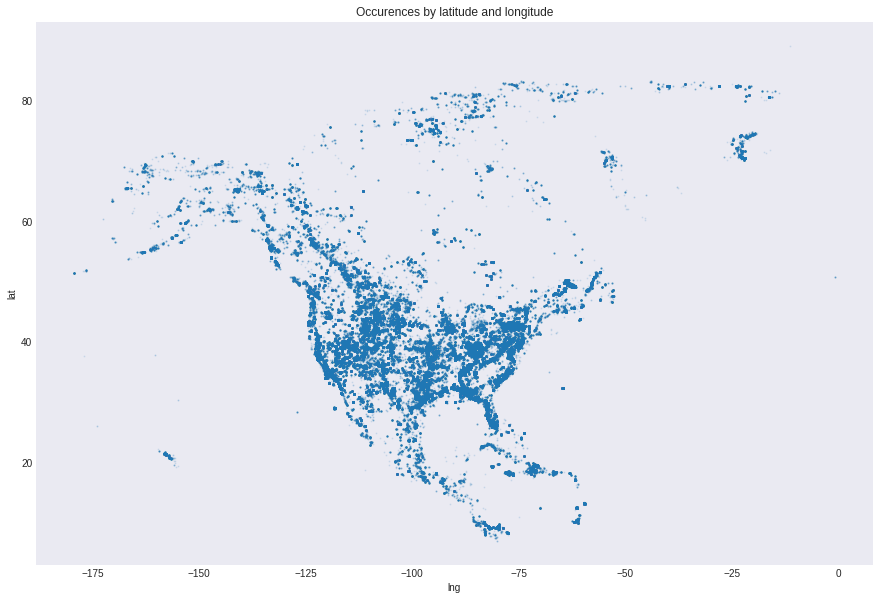

In [220]:
print('-'*160)
print("This program allows users to learn more about the geology surrounding their location by exploring paleotological findings from the area.\n")
print("Paleotontology involves the study of fossils, which are mineralized remains of living things. Fossils are found everywhere.\n")
print("Here is a scatterplot plotting the latitude and longitude of various fossils found in North America.")
print('-'*160)
plt.style.use('seaborn-dark')
# Filter out incorrectly placed geographical data and plot lat vs lng
occs.loc[occs['lat']>0].loc[occs['lng']<0].plot(kind='scatter', x='lng', y='lat', title='Occurences by latitude and longitude', figsize=(15, 10), s=1, alpha=0.1)

In [221]:
print('-'*160)
print("The program makes use of the Paleobiology Database, a database tracking millions of \"occurences\" of fossils referenced in research papers studying paleontology.", end='\n\n')
print("When a fossil is found as part of a study, information is collected about the fossil and the surrounding geological conditions. This information is represented" + '\n' + "as columns within a dataframe containing data imported from the Paleobiology Database, or PBDB.\n")
print("Each occurence represents a single species found at a site, and can contain multiple specimens.")
print('-'*160)
# Take random sample of rows from dataframe
occs.sample(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
The program makes use of the Paleobiology Database, a database tracking millions of "occurences" of fossils referenced in research papers studying paleontology.

When a fossil is found as part of a study, information is collected about the fossil and the surrounding geological conditions. This information is represented
as columns within a dataframe containing data imported from the Paleobiology Database, or PBDB.

Each occurence represents a single species found at a site, and can contain multiple specimens.
----------------------------------------------------------------------------------------------------------------------------------------------------------------


occurrence_no  collection_no            identified_name  \
487330        1336568         180263        Kockelella absidata   
354590         843848          93792        Manicina pliocenica   
116761         185549          18208            Eucastor tortus   
86874          139294          11919  Gryposaurus cf. notabilis   
309510         746974          80000            Sulcoretusa sp.   

       identified_rank  identified_no             difference  \
487330         species         309859  subjective synonym of   
354590         species         136469                    NaN   
116761         species          46358                    NaN   
86874          species          63251                    NaN   
309510           genus          12015                    NaN   

                accepted_name accepted_rank  accepted_no  early_interval  \
487330       Kockelella ortus       species     344783.0      Ludfordian   
354590    Manicina pliocenica       species     136469.0        Zanclean   
116761        Eucastor tortus       species      44958.0      Barstovian   
86874   Gryposaurus notabilis       species      63251.0  Late Campanian   
309510            Sulcoretusa         genus      12015.0      Piacenzian   

         max_ma   min_ma          ref_author  ref_pubyr  reference_no  \
487330  425.600  423.000      Barrick et al.     2010.0         59829   
354590    5.333    3.600    Budd and Johnson     1999.0         28516   
116761   15.970   13.600     Voorhies et al.     1987.0           781   
86874    83.500   70.600      Prieto-Márquez     2011.0         59147   
309510    3.600    2.588  Collins and Coates     1999.0         17667   

          phylum         class               order         family  \
487330  Chordata     Conodonta        Ozarkodinida  Kockelellidae   
354590  Cnidaria      Anthozoa        Scleractinia       Faviidae   
116761  Chordata      Mammalia            Rodentia     Castoridae   
86874   Chordata  Ornithischia  NO_ORDER_SPECIFIED  Hadrosauridae   
309510  Mollusca    Gastropoda       Cephalaspidea      Retusidae   

              genus  image_no abund_value abund_unit taxon_environment  \
487330   Kockelella     764.0         NaN        NaN            marine   
354590     Manicina    2036.0         NaN        NaN            marine   
116761     Eucastor    1247.0         NaN        NaN       terrestrial   
86874   Gryposaurus     994.0           1  specimens       terrestrial   
309510  Sulcoretusa    1831.0           3  specimens               NaN   

       environment_basis              motility motility_basis  \
487330        Vertebrata       actively mobile      Conodonta   
354590      Scleractinia  facultatively mobile       Manicina   
116761          Eutheria       actively mobile   Osteichthyes   
86874       Ornithischia       actively mobile   Ornithischia   
309510               NaN       actively mobile      Retusidae   

                 life_habit life_habit_basis          vision vision_basis  \
487330             nektonic        Conodonta  well-developed    Conodonta   
354590  low-level epifaunal         Manicina           blind     Anthozoa   
116761           amphibious       Castoridae             NaN          NaN   
86874                   NaN      Ornithopoda             NaN          NaN   
309510            epifaunal        Retusidae         limited   Gastropoda   

                  diet   diet_basis                         ontogeny  \
487330       carnivore    Conodonta                              NaN   
354590  microcarnivore     Manicina                              NaN   
116761         browser   Castoridae                              NaN   
86874        herbivore  Ornithopoda  accretion,modification of parts   
309510       carnivore    Retusidae                              NaN   

       ontogeny_basis ecospace_comments     composition      architecture  \
487330            NaN               NaN  hydroxyapatite               NaN   
354590            NaN  

----------------------------------------------------------------------------------------------------------------------------------------------------------------
This particular dataset includes data on 546979 occurences located in North America. The PBDB contains data on over 1.4 million occurences in total. This may 
seem like a lot, but the fossils you see here are not exactly the kind of fossil you may see in a museum.

A quick analysis of the different phylum (a classification rank) shows that Chordata, the phylum that mostly consists of vertebrates such as sharks and 
dinosaurs, makes up only 22% of all occurences.

A closer analysis of the different classes (a subset of phylums) shows that Reptilia, the class that dinosaurs fall under, make up just 3% of all occurences.
Although shark teeth are some of the most commonly owned fossils, they make up less than 1% of occurences under Chondrichthyes.  A majority of occurences
are classified as what most of us recognize as just "shells

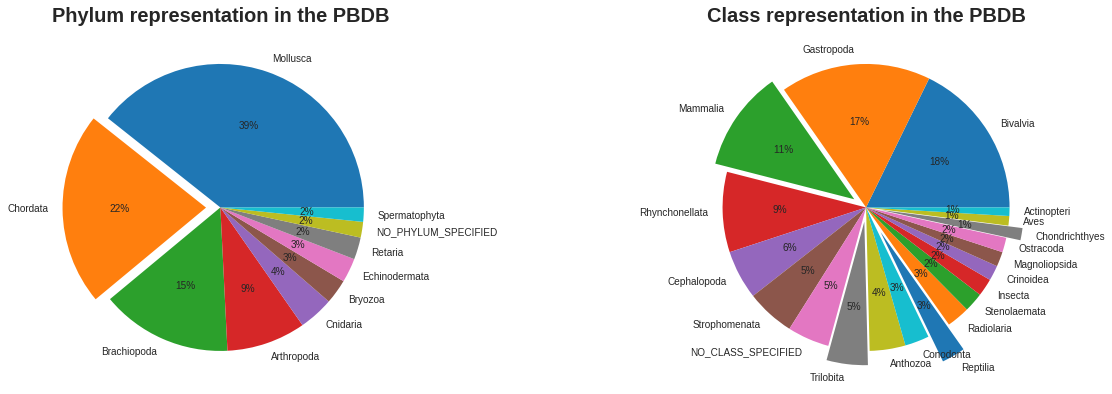

In [222]:
print('-'*160)
print("This particular dataset includes data on " + str(len(occs)) + " occurences located in North America. The PBDB contains data on over 1.4 million occurences in total. This may " + '\n' + "seem like a lot, but the fossils you see here are not exactly the kind of fossil you may see in a museum.", end = '\n\n')
print("A quick analysis of the different phylum (a classification rank) shows that Chordata, the phylum that mostly consists of vertebrates such as sharks and " + '\n' + "dinosaurs, makes up only 22% of all occurences.", end = '\n\n')
print("A closer analysis of the different classes (a subset of phylums) shows that Reptilia, the class that dinosaurs fall under, make up just 3% of all occurences." + '\n' + "Although shark teeth are some of the most commonly owned fossils, they make up less than 1% of occurences under Chondrichthyes.  A majority of occurences" + '\n' + "are classified as what most of us recognize as just \"shells\".")
print('-'*160 + '\n')
occs_pie = occs['class'].value_counts()[:20].rename_axis('class').to_frame('count')
# Display occurence data grouped by phylum and class
fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(18)
fig.subplots_adjust(wspace=0.8)
explode1 = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0)
explode2 = (0, 0, 0.1, 0, 0, 0, 0, 0.1, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0.1, 0, 0)
ax[0].pie(occs['phylum'].value_counts()[:10].rename_axis('phylum').to_frame('count')['count'],labels=occs['phylum'].value_counts()[:10].rename_axis('phylum').to_frame('count').index, explode=explode1, autopct='%1.f%%')
ax[0].set_title('Phylum representation in the PBDB',size=20, fontweight = 'bold')
ax[1].pie(occs['class'].value_counts()[:20].rename_axis('class').to_frame('count')['count'],labels=occs['class'].value_counts()[:20].rename_axis('class').to_frame('count').index, explode=explode2, autopct='%1.f%%')
ax[1].set_title('Class representation in the PBDB',size=20, fontweight = 'bold')
fig.show()

In [223]:
print('-'*160)
print("Additionally, even fossils that would be recognizeable by name may not be recognizeable as an occurence. This map of T-rex occurences shows",len(filter(occs, 'accepted_name', 'tyrannosaurus')), "total occurences. \nAre T-rexes that common?", end = '\n\n')
print("This is because a vast majority of vertebrate fossils are found incomplete. Just a single tooth or chunk of bone would still count as anoccurence as long as it" + '\n' + "is identifiable as T-rex with reasonable confidence. Considering T-rexes existed for 2 million years and regularly regenerated teeth, it makes sense that T-rex" + '\n' + "fossils are found relatively often.\n")
print("On the other hand, only a small percentage of fossils found end up in a paper and in the PBDB. Finds made by amateur collectors make up a majority of total \nfinds for many species, but almost never get recognized as an occurence in the PBDB.")
print('-'*160)
# Use heatmap() and filter() functions defined above to draw out map
heatmap(filter(occs, 'accepted_name', 'tyrannosaurus'), 'accepted_name', ['occurrence_no', 'formation.1', 'min_ma'], 6, 'Tyrannosaurus Rex Occurences').show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Additionally, even fossils that would be recognizeable by name may not be recognizeable as an occurence. This map of T-rex occurences shows 79 total occurences. 
Are T-rexes that common?

This is because a vast majority of vertebrate fossils are found incomplete. Just a single tooth or chunk of bone would still count as anoccurence as long as it
is identifiable as T-rex with reasonable confidence. Considering T-rexes existed for 2 million years and regularly regenerated teeth, it makes sense that T-rex
fossils are found relatively often.

On the other hand, only a small percentage of fossils found end up in a paper and in the PBDB. Finds made by amateur collectors make up a majority of total 
finds for many species, but almost never get recognized as an occurence in the PBDB.
----------------------------------------------------

#### Location-Specific Analysis

In [224]:
# tell user about what you can find around your area

print("-"*160+"\nEnter coordinates to get information about occurences in your area. Enter 0, 1, or 2 in the lat field to use preset coordinates.\n0 enters DC, 1 enters NYU, and 2 enters upstate NY.\n")
# User inputted information
local = {
    'lat': float(input("Enter Latitude: ")),
    'prx': float(input("Enter Search Radius (km): "))
}
# Preset coordinates
if local['lat'] == 0:
  local['lat'], local['lng'] = 38.954503, -77.247611
elif local['lat'] == 1:
  local['lat'], local['lng'] = 40.729009, -73.995959
elif local['lat'] == 2:
  local['lat'], local['lng']= 43.058888, -76.031289
else:
  local['lng'] = float(input("Enter Longitude: "))

proximity = distances(occs, local['lat'], local['lng'], local['prx'])
# Search report summary
print('-'*120)
print('Search Report Summary')
print('The search returned ' + str(len(proximity)) + ' occurences within ' + str(local['prx']) + ' kilometers of ' + str(local['lat']) + ', ' + str(local['lng']) + '.')
usa_occ_score, y_occ_score = round(100*409217/3797000,2), round(100*len(proximity)/spherical_sector_area(local['prx']),2)
print('Your search radius contains ' + str(y_occ_score) + ' occurences per square km, which is ' + str(abs(round(100*y_occ_score / usa_occ_score) - 100)) + "% " + ('higher' if 100*y_occ_score / usa_occ_score > 100 else 'lower') + ' than the national average of ' + str(usa_occ_score) + '.')
print('The average age of occurences within your search is',round(proximity['avg_ma'].mean(),2), 'million years.')
print('-'*120)
# Generate heatmap
heatmap(proximity, 'accepted_name', ['occurrence_no', 'formation.1', 'min_ma'], 6, 'Nearby Fossil Occurences').show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Enter coordinates to get information about occurences in your area. Enter 0, 1, or 2 in the lat field to use preset coordinates.
0 enters DC, 1 enters NYU, and 2 enters upstate NY.

Enter Latitude: 2
Enter Search Radius (km): 150
------------------------------------------------------------------------------------------------------------------------
Search Report Summary
The search returned 18235 occurences within 150.0 kilometers of 43.058888, -76.031289.
Your search radius contains 25.8 occurences per square km, which is 139% higher than the national average of 10.78.
The average age of occurences within your search is 401.14 million years.
------------------------------------------------------------------------------------------------------------------------


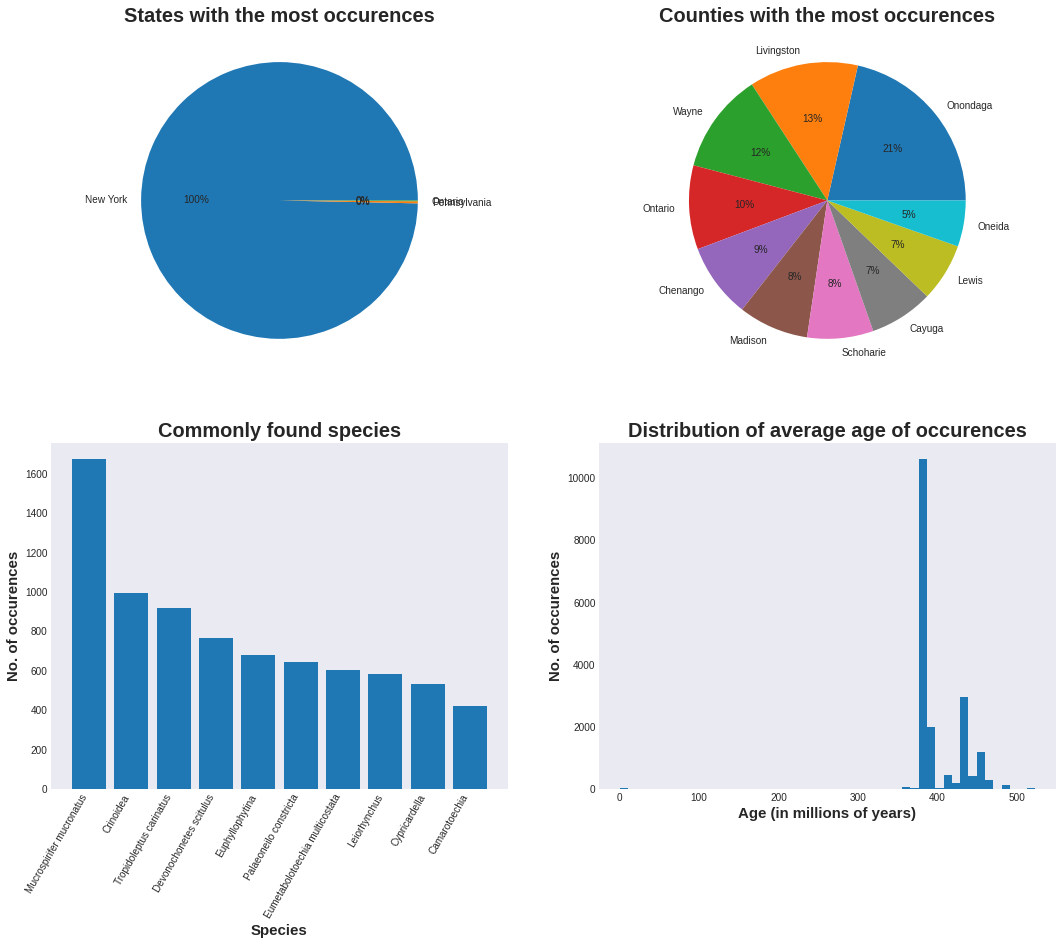

In [225]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(14)
fig.set_figwidth(18)
fig.subplots_adjust(wspace=0.2)
# Each chart converts the top n values of a value counts output to a dataframe and displays it as a chart
ax[0,0].pie(proximity['state'].value_counts()[:3].rename_axis('state').to_frame('count')['count'],labels=proximity['state'].value_counts()[:3].rename_axis('state').to_frame('count').index, autopct='%1.f%%')
ax[0,0].set_title('States with the most occurences',size=20, fontweight = 'bold')
ax[0,1].pie(proximity['county'].value_counts()[:10].rename_axis('county').to_frame('count')['count'],labels=proximity['county'].value_counts()[:10].rename_axis('county').to_frame('count').index, autopct='%1.f%%')
ax[0,1].set_title('Counties with the most occurences',size=20, fontweight = 'bold')
ax[1,0].bar(proximity['accepted_name'].value_counts()[:10].rename_axis('accepted_name').to_frame('count').index, height=proximity['county'].value_counts()[:10].rename_axis('accepted_name').to_frame('count')['count'],)
ax[1,0].set_title('Commonly found species',size=20, fontweight = 'bold')
ax[1,0].set_xticklabels(proximity['accepted_name'].value_counts()[:10].rename_axis('accepted_name').to_frame('count').index, Rotation='60', ha="right")
ax[1,0].set_xlabel("Species",size=15, fontweight = 'bold')
ax[1,0].set_ylabel("No. of occurences",size=15, fontweight = 'bold')
ax[1,1].hist(proximity['avg_ma'],bins=50)
ax[1,1].set_title('Distribution of average age of occurences',size=20, fontweight = 'bold')
ax[1,1].set_xlabel("Age (in millions of years)",size=15, fontweight = 'bold')
ax[1,1].set_ylabel("No. of occurences",size=15, fontweight = 'bold')
fig.show()

In [238]:
# group, formation, member
print("-"*160+"\nGroups, Formations, and Members are geological groups used to classify fossils from the same time period and environment.\n\nThis information can usually be found in research papers. However, to our knowledge there are no existing tools that can aggregate locations for formations and \ntheir breakdown into individual members. Knowing the location and characteristics of formations is essential in understanding the geology of a location. \n\nThis tool lists out a table showing the different members within the user's vicinity and maps the coordinates. This allows users to get a\ncomprehensive breakdown of formations nearby without having to read through many research papers.\n"+"-"*160)
group_age = proximity.groupby('stratgroup.1')['avg_ma'].mean().sort_values()
formation_age = proximity.groupby('formation.1')['avg_ma'].mean().sort_values()
member_age = proximity.groupby('member.1')['avg_ma'].mean().sort_values()
gmf = proximity.groupby(['stratgroup.1', 'formation.1','member.1','avg_ma']).mean()
gmf.drop(gmf.columns.difference(['lng','lat']), 1, inplace=True)
gmf_r = gmf.reset_index()
heatmap(gmf_r, 'member.1',['avg_ma','formation.1','stratgroup.1'],10,'Estimated Location of Members, Formations, and Groups').show()
gmf

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Groups, Formations, and Members are geological groups used to classify fossils from the same time period and environment.

This information can usually be found in research papers. However, to our knowledge there are no existing tools that can aggregate locations for formations and 
their breakdown into individual members. Knowing the location and characteristics of formations is essential in understanding the geology of a location. 

This tool lists out a table showing the different members within the user's vicinity and maps the coordinates. This allows users to get a
comprehensive breakdown of formations nearby without having to read through many research papers.
----------------------------------------------------------------------------------------------------------------------------------------------------------------


lng        lat
stratgroup.1 formation.1 member.1     avg_ma                      
Beekmantown  Tribes Hill Canyon Road  481.55 -74.308818  42.962072
                                      482.00 -74.266310  42.950754
                         Sprakers     481.55 -74.262039  42.978649
                                      482.00 -74.556664  42.902500
                         Van Wie      481.55 -74.372107  42.939645
...                                                 ...        ...
Tully        Tully       middle Tully 385.20 -75.014544  42.564545
                         upper        385.20 -75.626907  42.728202
                         upper Tully  385.20 -75.609018  42.701105
West Falls   Chemung     Cayuta       377.45 -76.357002  42.346001
                         Lower        377.45 -76.489998  42.209999

[115 rows x 2 columns]

----------------------------------------------------------------------------------------------------------------------------------------------------------------
It looks as though your surroundings are mainly composed of former marine life. Compare the age distribution chart with the formations chart above to get a 
rough guess of the environments that makes up the fossils of the different formations.
----------------------------------------------------------------------------------------------------------------------------------------------------------------


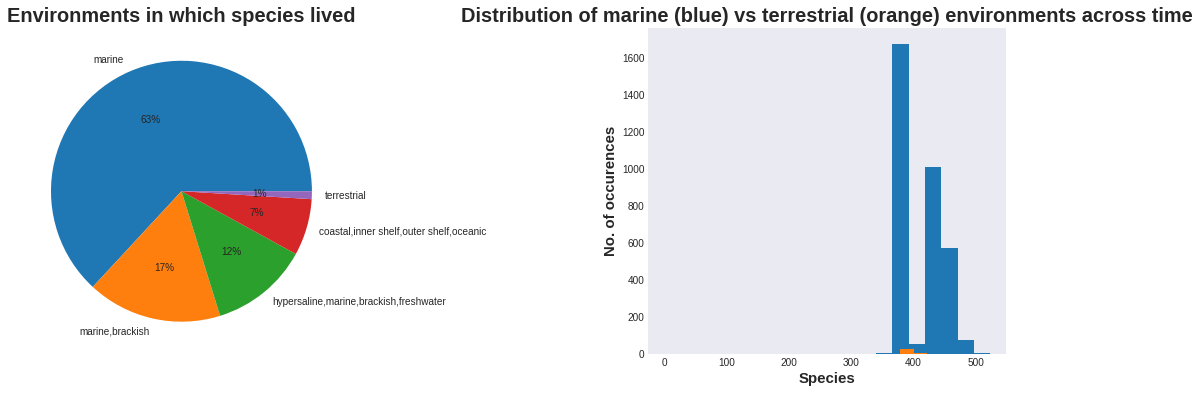

In [251]:
print("-"*160 + "\nIt looks as though your surroundings are mainly composed of former " + str(proximity['taxon_environment'].value_counts().sort_values().index[-1]) + " life. Compare the age distribution chart with the formations chart above to get a \nrough guess of the environments that makes up the fossils of the different formations.\n" + "-"*160)
fig, ax = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(18)
fig.subplots_adjust(wspace=0.8)
taxon_ages = proximity[['taxon_environment', 'avg_ma']].dropna()
ax[0].pie(proximity['taxon_environment'].value_counts()[:5].rename_axis('taxon_environment').to_frame('count')['count'],labels=proximity['taxon_environment'].value_counts()[:5].rename_axis('taxon_environment').to_frame('count').index, autopct='%1.f%%')
ax[0].set_title('Environments in which species lived',size=20, fontweight = 'bold')
ax[1].hist(taxon_ages.loc[taxon_ages['taxon_environment'].str.contains('marine', na=False)]['avg_ma'], bins=20)
ax[1].hist(taxon_ages.loc[taxon_ages['taxon_environment'].str.contains('terr', na=False)]['avg_ma'], bins=20)
ax[1].set_title('Distribution of marine (blue) vs terrestrial (orange) environments across time',size=20, fontweight = 'bold')
ax[1].set_xlabel("Species",size=15, fontweight = 'bold')
ax[1].set_ylabel("No. of occurences",size=15, fontweight = 'bold')
fig.show()

In [255]:
# track paleological location over time
print("-"*160 + "\nOne important data point included in the PBDB is paleolocation, or where on earth the occurence was located when it was alive. Since the PBDB provides \nboth paleolocation and age data, we can combine these and track the movement of your geology over the past 500 millions years across the earth. To account for \nmissing data points, the program uses a spline interpolation to fill in the missing coordinates.\n "+"-"*160)
# Extract only relevant info from user specific data
paleoprx = distances(occs, local['lat'], local['lng'], local['prx'] if input("Scale up search radius to increase accuracy? (Y/N) ") == 'N' else 300)
paleoloc = paleoprx[['avg_ma','paleolat','paleolng']]
paleoloc['avg_ma'] = paleoloc['avg_ma'].round(0)
# Create empty dataframe to use to merge with populated dataframe in order to automatically fill in NaN for missing values
empty = pd.DataFrame(index=np.arange(528), columns=np.arange(0))
empty.reset_index(inplace=True)
empty.rename(columns={'index': "avg_ma"}, inplace=True)
# Sort and group resulting data, and interpolate missing data points
locs = pd.merge(paleoloc.groupby('avg_ma')['paleolat'].mean().sort_values(), paleoloc.groupby('avg_ma')['paleolng'].mean().sort_values(), how='inner', on='avg_ma')
paleoloc_ = pd.merge(empty, locs, how='left', on='avg_ma')
paleoloc_.sort_values('avg_ma',inplace=True)
paleoloc_['paleolat'] = paleoloc_['paleolat'].interpolate(method='spline', order=2)
paleoloc_['paleolng'] = paleoloc_['paleolng'].interpolate(method='spline', order=2)
# Display relevant data as a heatmap
heatmap(paleoloc_.rename(columns={'paleolat': "lat", 'paleolng': "lng"}), 'avg_ma', ['lat', 'lng'], 10, 'Track Your Geology Over Time').show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------
One important data point included in the PBDB is paleolocation, or where on earth the occurence was located when it was alive. Since the PBDB provides 
both paleolocation and age data, we can combine these and track the movement of your geology over the past 500 millions years across the earth. To account for 
missing data points, the program uses a spline interpolation to fill in the missing coordinates.
 ----------------------------------------------------------------------------------------------------------------------------------------------------------------
Scale up search radius to increase accuracy? (Y/N) Y


#### Tests
---


Actual interpolation


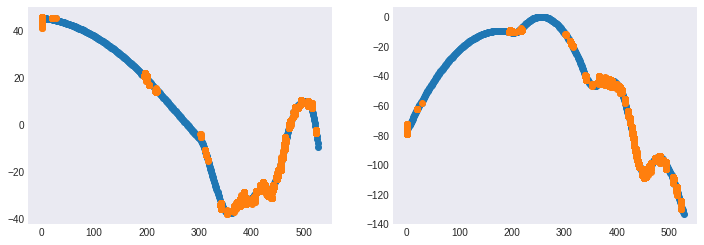

In [229]:
# Tests
print("Actual interpolation")
fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(12)
ax[0].scatter(paleoloc_['avg_ma'], paleoloc_['paleolat'])
ax[0].scatter(paleoloc['avg_ma'], paleoloc['paleolat'])
ax[1].scatter(paleoloc_['avg_ma'], paleoloc_['paleolng'])
ax[1].scatter(paleoloc['avg_ma'], paleoloc['paleolng'])
fig.show()

In [230]:
# Heatmap using data before interpolation
heatmap(paleoloc.rename(columns={'paleolat': "lat", 'paleolng': "lng"}), 'avg_ma', ['lat', 'lng'], 10, 'Track Your Geology Over Time').show()

## Occurence Search Tools

### Search by species


In [231]:
heatmap(filter(occs, 'accepted_name', input('Enter specimen name: ')), 'accepted_name', ['occurrence_no', 'formation.1', 'min_ma'], 6, 'Specimens Map').show()

Enter specimen name: trilobit


### Search by state

In [232]:
heatmap(filter(occs, 'state', input('Enter state: ')), 'state', ['occurrence_no', 'formation.1', 'min_ma'], 6, 'Specimens Map').show()

Enter state: New York


## General Data Visualizations

In [233]:
import requests
import io
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
pd.options.mode.chained_assignment = None

In [234]:
states = occs.loc[occs['cc'] == 'US']
states = states.groupby(['state'])['max_ma'].mean()
#We would like to see what states the oldest fossils would be located and where the youngest are
#This could give us insights into the previous environments of the current states
states = pd.DataFrame(states)
states = states.sort_values(by='max_ma',ascending=False)
states = states.reset_index()
states = states[states.state != ('Califormia','Flrida','Sussex','Michiagn','florida','Unknown','')]
states = states.sort_values(by = 'max_ma',ascending = False)
states = states.set_index('state')

Text(0.5, 0, 'Average Age of Fossils in Millions')

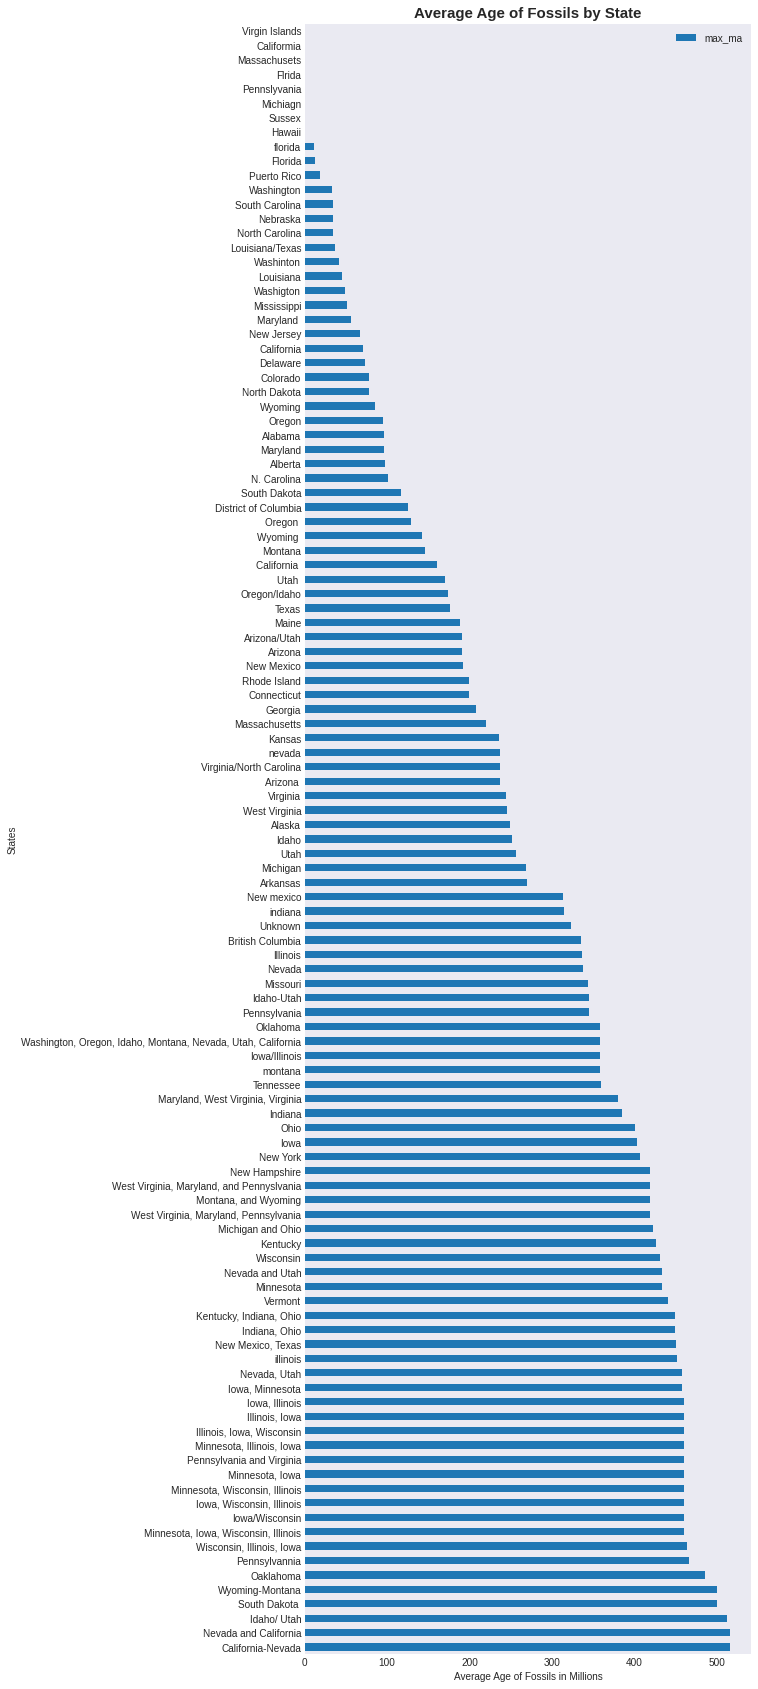

In [235]:
fig, ax = plt.subplots()
states.plot.barh(figsize = (8,30), ax=ax)
ax.set_title('Average Age of Fossils by State',size=15, fontweight = 'bold')
ax.set_ylabel('States')
ax.set_xlabel('Average Age of Fossils in Millions')

In [236]:
rank = occs.groupby('identified_rank')['max_ma'].mean()
rank = pd.DataFrame(rank)
rank = rank.reset_index()
rank = rank.loc[(rank['identified_rank']).isin(['kingdom','phylum','class','order','family','genus','species'])]
rank = rank.reindex([6,8,0,7,1,2,9])
rank


identified_rank      max_ma
6         kingdom  166.153996
8          phylum  318.027774
0           class  288.973864
7           order  258.718479
1          family  102.719258
2           genus  230.715823
9         species  187.043246

Text(0.5, 0, 'Average Age of Fossils in Millions for Each Respective Rank')

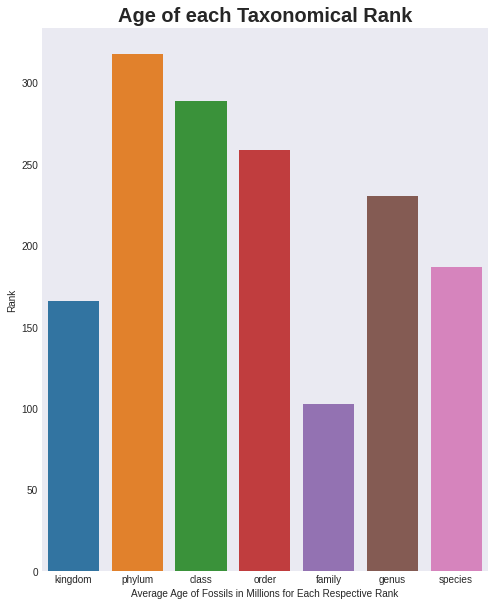

In [237]:
fig = plt.figure(figsize=(8,10))               
sns.barplot(x='identified_rank', y= 'max_ma', data=rank) 
plt.title('Age of each Taxonomical Rank',fontsize=20,fontweight= 'bold')
plt.ylabel('Rank')
plt.xlabel('Average Age of Fossils in Millions for Each Respective Rank')